# Set environment

In [323]:
library(tidyverse)
library(glmnet)
library(gridExtra)
library(pROC)

In [220]:
DIR_DAT = "/data/Duke_BIOS824/res_proj01"

In [221]:
dir(DIR_DAT)

[1] "df_img_area_perimeter.csv" "img_mask.pickle"          
[3] "img_slice.pickle"          "label.csv"

In [222]:
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               #legend.margin = unit(0, "cm"),
               legend.margin = margin(0, 0, 0, 0, unit = "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
}

In [281]:
resetPar <- function() {
    dev.new()
    op <- par(no.readonly = TRUE)
    dev.off()
    op
}

# Import data

In [342]:
label      = read_csv(file.path(DIR_DAT, "label_split.csv"))
df_img_sum = read_csv(file.path(DIR_DAT, "df_img_area_perimeter.csv"))

Parsed with column specification:
cols(
  Patient = col_character(),
  COCCluster = col_double(),
  neoplasm_histologic_grade = col_double(),
  type = col_character()
)
Parsed with column specification:
cols(
  Patient = col_character(),
  Slice = col_double(),
  Area = col_double(),
  Perimeter = col_double()
)


# Summarize the data

In [343]:
df = df_img_sum %>% 
    filter(Area > 1) %>% 
    group_by(Patient) %>% 
    summarize(
        area_mu  = mean(Area), 
        area_max = max(Area),
        peri_mu  = mean(Perimeter),
        peri_max = max(Perimeter),
        ratio_pa_mu  = mean(Perimeter / Area),
        ratio_pa_max = max(Perimeter / Area)) %>%
    separate(Patient, c("x", "y", "z"), sep = "_", extra = "drop") %>%
    unite(Patient, x, y, z, sep = "_") %>%
    inner_join(label, ., by = "Patient") %>%
    mutate(COCCluster = as.character(COCCluster)) %>%
    mutate(neoplasm_histologic_grade = as.character(neoplasm_histologic_grade))

df_combine = df

check the results

In [344]:
print(nrow(df_combine))
print(all(unique(df_combine$Patient) == df_combine$Patient))

[1] 110
[1] TRUE


In [345]:
df_combine %>% head

Patient,COCCluster,neoplasm_histologic_grade,type,area_mu,area_max,peri_mu,peri_max,ratio_pa_mu,ratio_pa_max
TCGA_CS_4941,2,2,train,1797.3750,2877,858.2500,1362,0.5656701,1.0000000
TCGA_CS_4942,1,2,train,1185.3333,1539,489.6667,557,0.4203328,0.4651774
TCGA_CS_4943,1,2,train,1816.8750,3086,623.2500,895,0.4117224,0.6626263
TCGA_CS_4944,1,1,train,3123.3333,6189,828.5556,1206,0.3865835,0.7420814
TCGA_CS_5393,1,2,train,3748.7500,5855,1036.6250,1486,0.3562005,0.8142292
TCGA_CS_5395,2,1,train,785.3333,840,408.3333,435,0.5197297,0.5569782


# Visualization

In [346]:
ys =      c("area_mu",      "Area (Mean)") %>%
    rbind(c("area_max",     "Area (Max)")) %>%
    rbind(c("peri_mu",      "Perimeter (Mean)")) %>%
    rbind(c("peri_max",     "Perimeter (Max)"))  %>%
    rbind(c("ratio_pa_mu",  "Perimeter/Area (Mean)")) %>%
    rbind(c("ratio_pa_max", "Perimeter/Area (Max)"))  %>%
    as.data.frame
    
rownames(ys) = NULL
colnames(ys) = c("Y", "Ylabel")

ys = ys %>%
    group_by(Y, Ylabel) %>%
    tidyr::expand(X = c("COCCluster", "neoplasm_histologic_grade")) %>% 
    mutate(Xlabel = ifelse(X == "COCCluster", "COCCluster", "Grade")) %>%
    arrange(X, Y) %>%
    select(X, Xlabel, Y, Ylabel) %>%
    t %>% as.data.frame(stringsAsFactors = FALSE)
ys

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
X,COCCluster,COCCluster,COCCluster,COCCluster,COCCluster,COCCluster,neoplasm_histologic_grade,neoplasm_histologic_grade,neoplasm_histologic_grade,neoplasm_histologic_grade,neoplasm_histologic_grade,neoplasm_histologic_grade
Xlabel,COCCluster,COCCluster,COCCluster,COCCluster,COCCluster,COCCluster,Grade,Grade,Grade,Grade,Grade,Grade
Y,area_max,area_mu,peri_max,peri_mu,ratio_pa_max,ratio_pa_mu,area_max,area_mu,peri_max,peri_mu,ratio_pa_max,ratio_pa_mu
Ylabel,Area (Max),Area (Mean),Perimeter (Max),Perimeter (Mean),Perimeter/Area (Max),Perimeter/Area (Mean),Area (Max),Area (Mean),Perimeter (Max),Perimeter (Mean),Perimeter/Area (Max),Perimeter/Area (Mean)


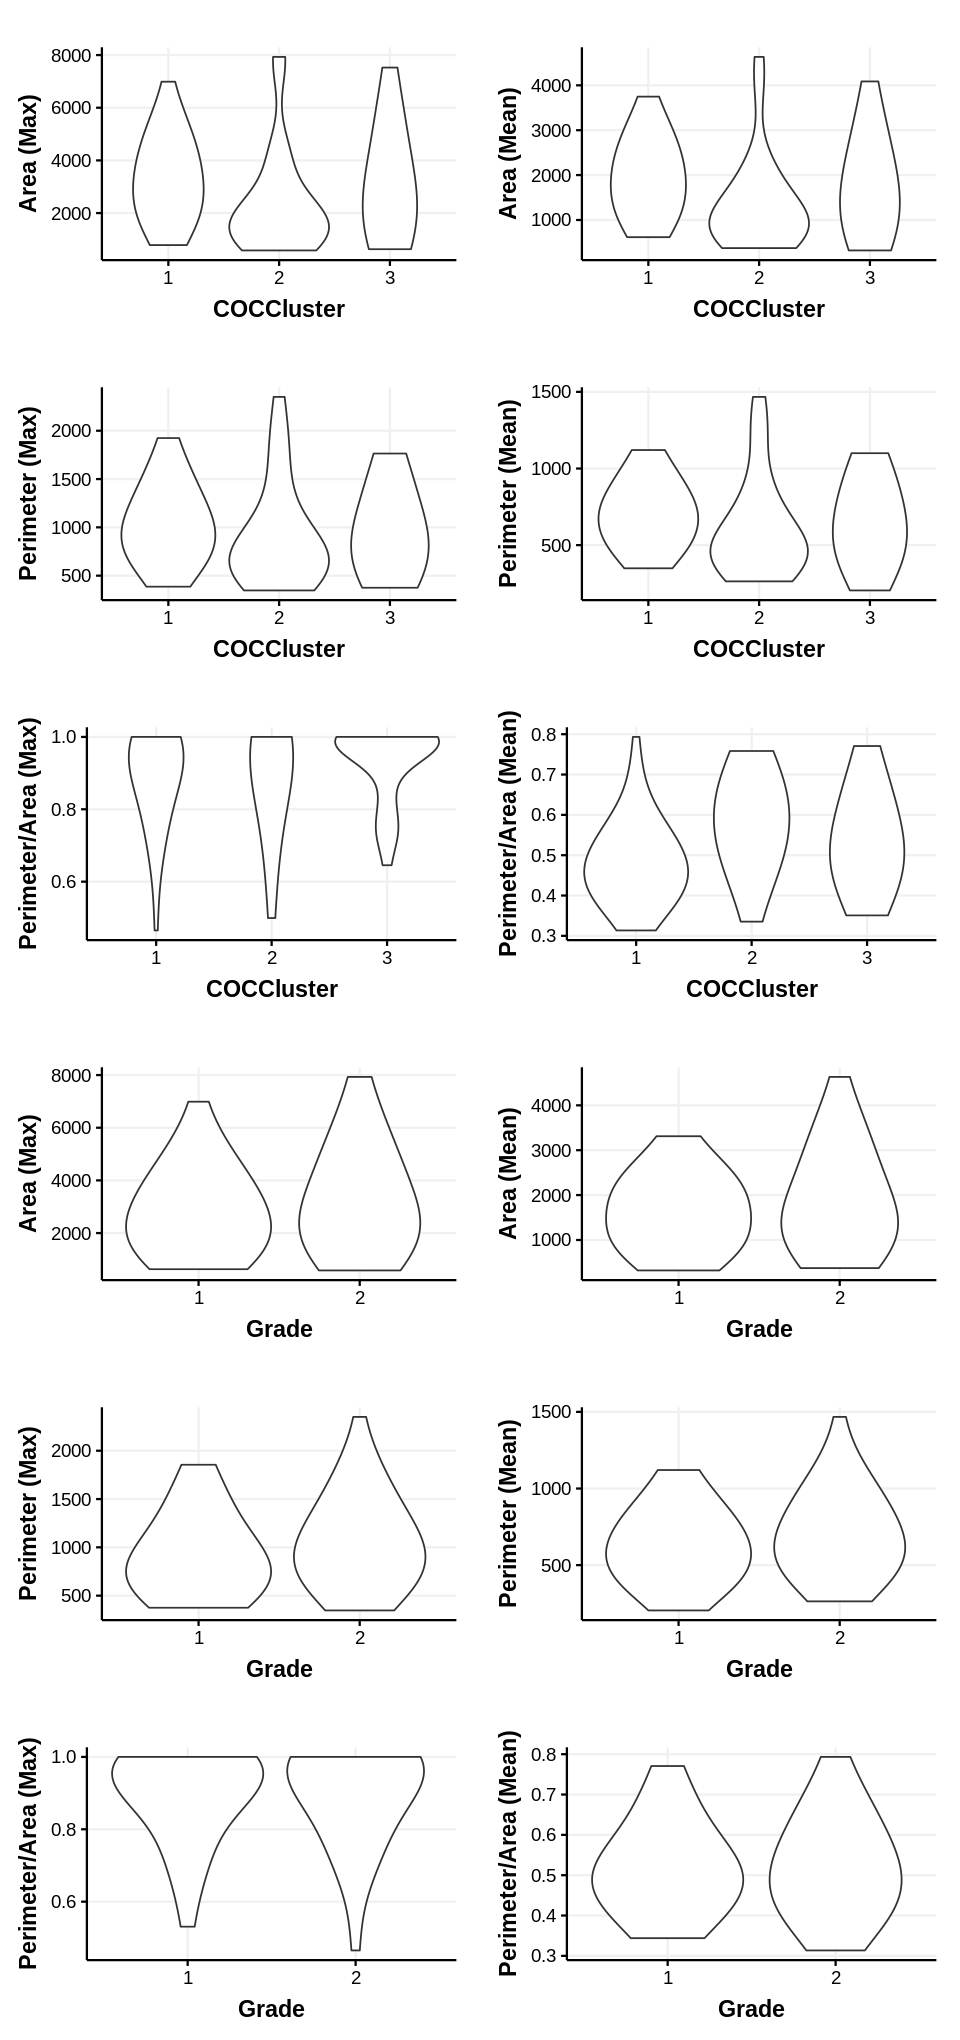

In [347]:
options(repr.plot.height=17, repr.plot.width=8)
dat = df_combine %>% na.omit

gps = lapply(ys, function(col){
    x      = col[1]
    xlabel = col[2]
    y      = col[3]
    ylabel = col[4]
    
    #gp = c(x, y, xlabel, ylabel)
    gp = dat %>%
        ggplot(aes_string(x = x, y = y)) + 
        geom_violin(adjust = 2) + 
        labs(x = xlabel, y = ylabel) + 
        theme_Publication()
    return(gp)
})

do.call("grid.arrange", c(gps, ncol=2))

# Cross validation

In [402]:
df_train = df_combine %>% filter(type == "train")
y_train  = df_train   %>% select(COCCluster, neoplasm_histologic_grade)
x_train  = df_train   %>% select(-Patient, -COCCluster, -neoplasm_histologic_grade, -type)
x_train  = x_train    %>% as.matrix

df_test  = df_combine %>% filter(type == "test")
y_test   = df_test    %>% select(COCCluster, neoplasm_histologic_grade)
x_test   = df_test    %>% select(-Patient, -COCCluster, -neoplasm_histologic_grade, -type)
x_test   = x_test     %>% as.matrix

ERROR: Error in parse(text = x, srcfile = src): <text>:1:6: unexpected symbol
1: from sklearn.model_selection
         ^


In [ ]:
for train_index, test_index in kf.split(X):

# Lasso Model

In [349]:
df_combine %>% head(3)

Patient,COCCluster,neoplasm_histologic_grade,type,area_mu,area_max,peri_mu,peri_max,ratio_pa_mu,ratio_pa_max
TCGA_CS_4941,2,2,train,1797.375,2877,858.2500,1362,0.5656701,1.0000000
TCGA_CS_4942,1,2,train,1185.333,1539,489.6667,557,0.4203328,0.4651774
TCGA_CS_4943,1,2,train,1816.875,3086,623.2500,895,0.4117224,0.6626263


In [362]:
df_train = df_combine %>% filter(type == "train")
y_train  = df_train   %>% select(COCCluster, neoplasm_histologic_grade)
x_train  = df_train   %>% select(-Patient, -COCCluster, -neoplasm_histologic_grade, -type)
x_train  = x_train    %>% as.matrix

df_test  = df_combine %>% filter(type == "test")
y_test   = df_test    %>% select(COCCluster, neoplasm_histologic_grade)
x_test   = df_test    %>% select(-Patient, -COCCluster, -neoplasm_histologic_grade, -type)
x_test   = x_test     %>% as.matrix

In [396]:
lstlabel_train = lapply(c("1", "2", "3"), function(target){
    y = y_train$COCCluster
    y = ifelse(y == target, 1, 0)
    y = as.factor(y)
    return(y)
})

lstlabel_test = lapply(c("1", "2", "3"), function(target){
    y = y_test$COCCluster
    y = ifelse(y == target, 1, 0)
    y = as.factor(y)
    return(y)
})

In [397]:
lstfit = lapply(lstlabel_train, function(y){
    fit = glmnet(x_train, y, alpha = 1, family="binomial")
    return(fit)
})

In [365]:
#fit = lstfit[[3]]
#coef(fit)

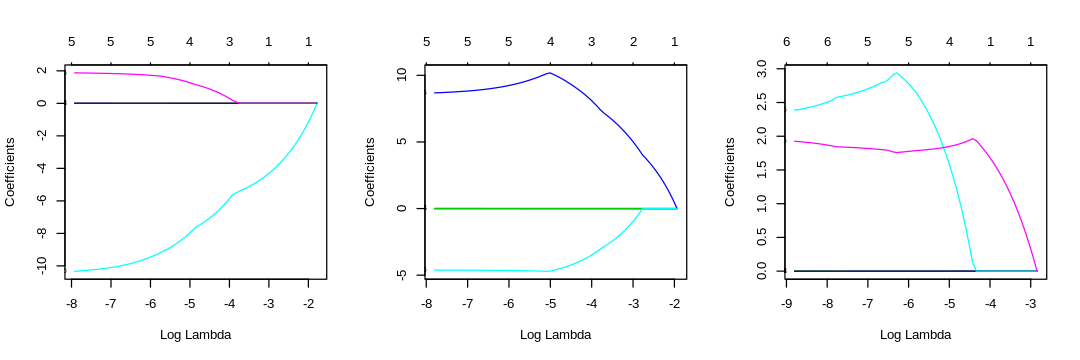

In [384]:
options(repr.plot.height=3, repr.plot.width=9)
par(mfrow = c(1,3)) ## some random par change

plot(lstfit[[1]], xvar="lambda", label = TRUE)
plot(lstfit[[2]], xvar="lambda", label = TRUE)
plot(lstfit[[3]], xvar="lambda", label = TRUE)

par(resetPar()) ## reset the pars to defaults

In [398]:
lstcvfit = lapply(lstlabel_train, function(y){
    cvfit <- cv.glmnet(x_train, y=y, alpha=1, family="binomial")
    return(cvfit)
})

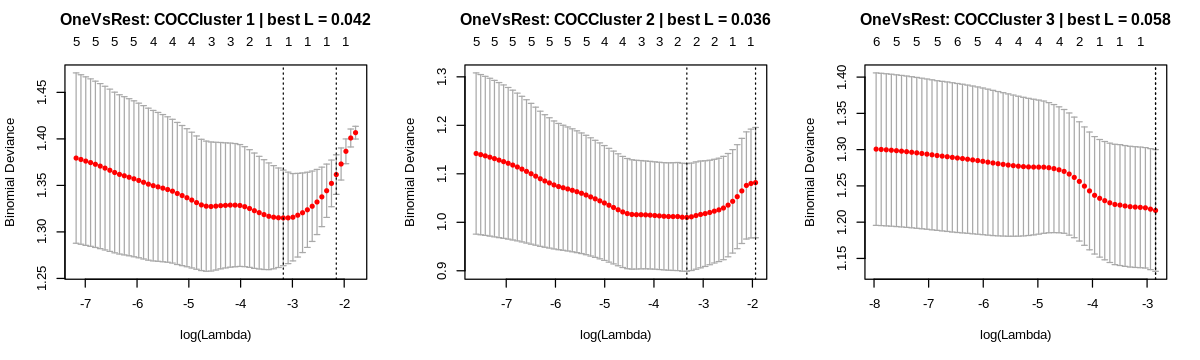

In [399]:
options(repr.plot.height=3, repr.plot.width=10)
par(mfrow = c(1,3)) ## some random par change

cvfit = lstcvfit[[1]]
best_lambda = round(cvfit$lambda.min, digits = 3)
plot(cvfit)
title(paste("OneVsRest: COCCluster 1 | best L =", best_lambda), line = 2.5)

cvfit = lstcvfit[[2]]
best_lambda = round(cvfit$lambda.min, digits = 3)
plot(cvfit)
title(paste("OneVsRest: COCCluster 2 | best L =", best_lambda), line = 2.5)

cvfit = lstcvfit[[3]]
best_lambda = round(cvfit$lambda.min, digits = 3)
plot(cvfit)
title(paste("OneVsRest: COCCluster 3 | best L =", best_lambda), line = 2.5)


par(resetPar()) ## reset the pars to defaults

# Lasso Model ROC

In [ ]:
y_test$COCCluster

In [400]:
lst_pred = lapply(lstcvfit, function(cvfit){
    pred = predict(cvfit, s='lambda.min', newx=x_test, type="response")
    return(pred[,1])
})

lst_roc = lapply(1:3, function(idx){
    cvfit = lstcvfit[[idx]]
    y     = lstlabel_test[[idx]]
    pred  = lst_pred[[idx]]

    res_roc = roc(y, pred)
    return(res_roc)
})

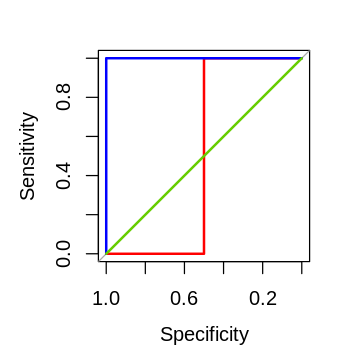

In [401]:
options(repr.plot.height=3, repr.plot.width=3)

plot.roc(lst_roc[[1]], col = "red")
lines(lst_roc[[2]], col = "blue")
lines(lst_roc[[3]], col = "chartreuse3")

In [286]:
round(cvfit$lambda.min, digits = 3) 

[1] 0.066

In [266]:
coef(fit)

   [[ suppressing 54 column names ‘s0’, ‘s1’, ‘s2’ ... ]]


7 x 54 sparse Matrix of class "dgCMatrix"
                                                                             
(Intercept)  -0.9808293 -1.1956386 -1.3957380 -1.5820914 -1.7555628 -1.916939
area_mu       .          .          .          .          .          .       
area_max      .          .          .          .          .          .       
peri_mu       .          .          .          .          .          .       
peri_max      .          .          .          .          .          .       
ratio_pa_mu   .          .          .          .          .          .       
ratio_pa_max  .          0.2385461  0.4603462  0.6665516  0.8581914  1.036200
                                                                           
(Intercept)  -2.066948 -2.206270 -2.335546 -2.455386 -2.58697330 -2.7100980
area_mu       .         .         .         .         .           .        
area_max      .         .         .         .         .           .        
peri_mu       .         .     

In [265]:
coef(cvfit, s = "lambda.min")

7 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept)  -0.9808293
area_mu       .        
area_max      .        
peri_mu       .        
peri_max      .        
ratio_pa_mu   .        
ratio_pa_max  .        

In [269]:
x_test = x
pred = predict(cvfit, s='lambda.min', newx=x_test, type="response")

In [272]:
p = -0.9808293
1 / (1 + exp(-p))

[1] 0.2727273

In [273]:
pred %>% head

1
0.2727273
0.2727273
0.2727273
0.2727273
0.2727273
0.2727273


# Lasso Model (v2)

In [ ]:
y = df_combine$COCCluster
y = ifelse(y == "3", 1, 0)
y = as.factor(y)
print(y)
x = df_combine %>% select(-Patient, -COCCluster, -neoplasm_histologic_grade) %>% as.matrix
x %>% head

In [149]:
ys =  c("area_mu", "Area (Mean)")
ys = cbind(ys, c("area_max", "Area (Max)"))

ys = data.frame(t(ys))
rownames(ys) = NULL
colnames(ys) = c("Y", "Ylabel")
print(ys)

         Y      Ylabel
1  area_mu Area (Mean)
2 area_max  Area (Max)


In [153]:
ys = ys %>% 
    group_by(Y, Ylabel) %>% 
    expand(X = c("COCCluster", "neoplasm_histologic_grade")) %>% #slice(rep(1:n(), each = 2))
    arrange(X, Y)
ys

Y,Ylabel,X
area_max,Area (Max),COCCluster
area_mu,Area (Mean),COCCluster
area_max,Area (Max),neoplasm_histologic_grade
area_mu,Area (Mean),neoplasm_histologic_grade


In [155]:
apply(ys, 1, function(row){row["X"]})

[1] "COCCluster"                "COCCluster"               
[3] "neoplasm_histologic_grade" "neoplasm_histologic_grade"

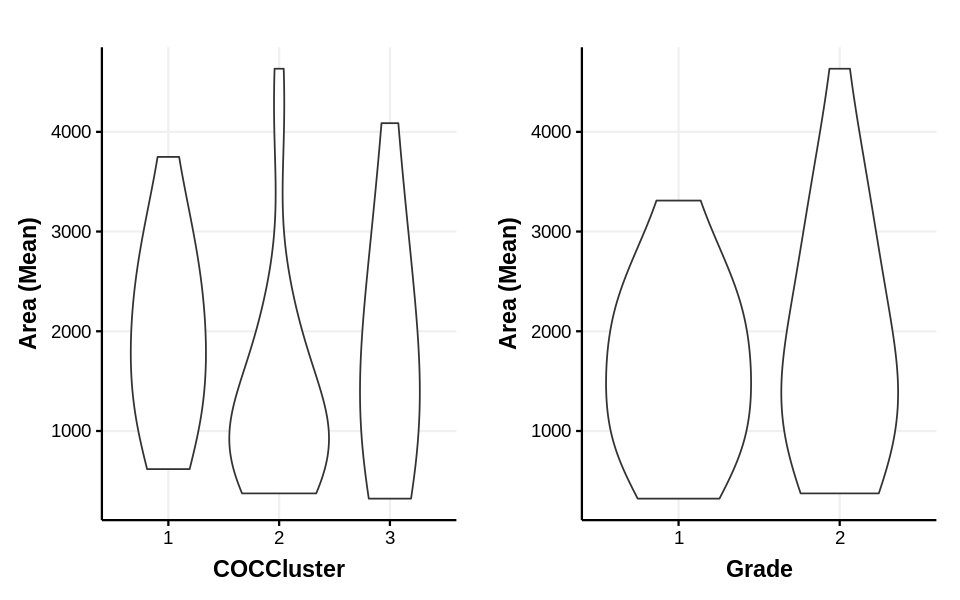

In [121]:
x = "COCCluster"; xlabel = x
y = "area_mu";    ylabel = "Area (Mean)"
gp1 = dat %>%
    ggplot(aes_string(x = x, y = y)) + 
    geom_violin(adjust = 2) + 
    labs(x = xlabel, y = ylabel) + 
    theme_Publication()

x = "neoplasm_histologic_grade"; xlabel = "Grade"
y = "area_mu";                   ylabel = "Area (Mean)"
gp2 = dat %>%
    ggplot(aes_string(x = x, y = y)) + 
    geom_violin(adjust = 2) + 
    labs(x = xlabel, y = ylabel) + 
    theme_Publication()

grid.arrange(gp1, gp2, ncol = 2)

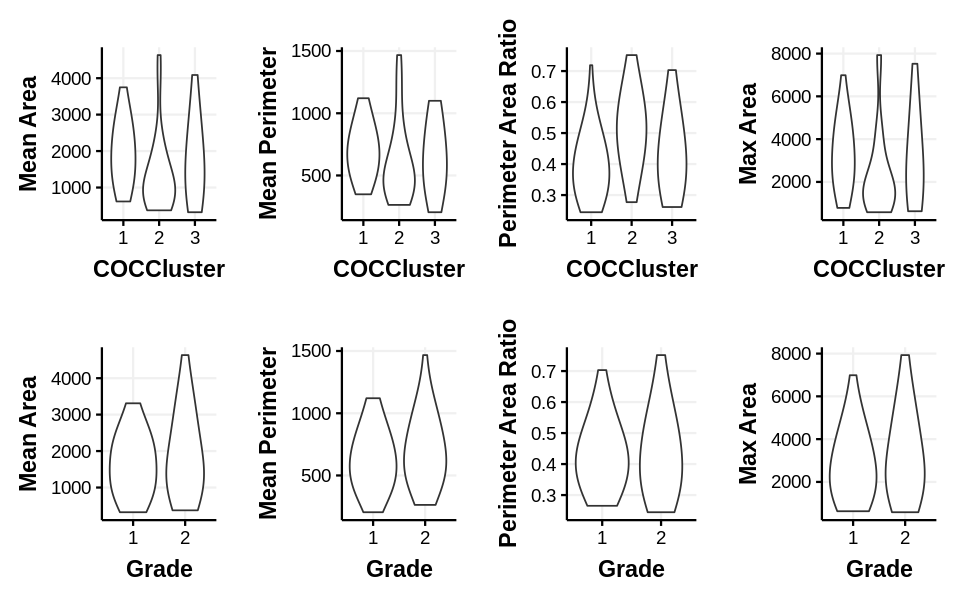

In [101]:
options(repr.plot.width=8, repr.plot.height=5)
dat = df_combine %>% na.omit

x = 
gp1 = dat %>%
    ggplot(aes(x = as.character(COCCluster), y = area_mu)) + 
    geom_violin(adjust = 2) + 
    labs(x = "COCCluster", y = "Mean Area") + 
    theme_Publication()

gp2 = dat %>%
    ggplot(aes(x = as.character(COCCluster), y = area_mu)) + 
    geom_violin(adjust = 2) + 
    labs(x = "COCCluster", y = "Mean Area") + 
    theme_Publication()

gp2 = dat %>%
    ggplot(aes(x = as.character(COCCluster), y = peri_mu)) + 
    geom_violin(adjust = 2) + 
    labs(x = "COCCluster", y = "Mean Perimeter") + 
    theme_Publication()

gp3 = dat %>%
    ggplot(aes(x = as.character(COCCluster), y = peri_area_ratio)) + 
    geom_violin(adjust = 2) + 
    labs(x = "COCCluster", y = "Perimeter Area Ratio") + 
    theme_Publication()

gp4 = dat %>%
    ggplot(aes(x = as.character(COCCluster), y = area_max)) + 
    geom_violin(adjust = 2) + 
    labs(x = "COCCluster", y = "Max Area") + 
    theme_Publication()

gp5 = dat %>%
    ggplot(aes(x = as.character(neoplasm_histologic_grade), y = area_mu)) + 
    geom_violin(adjust = 2) + 
    labs(x = "Grade", y = "Mean Area") + 
    theme_Publication()

gp6 = dat %>%
    ggplot(aes(x = as.character(neoplasm_histologic_grade), y = peri_mu)) + 
    geom_violin(adjust = 2) + 
    labs(x = "Grade", y = "Mean Perimeter") + 
    theme_Publication()

gp7 = dat %>%
    ggplot(aes(x = as.character(neoplasm_histologic_grade), y = peri_area_ratio)) + 
    geom_violin(adjust = 2) + 
    labs(x = "Grade", y = "Perimeter Area Ratio") + 
    theme_Publication()

gp8 = dat %>%
    ggplot(aes(x = as.character(neoplasm_histologic_grade), y = area_max)) + 
    geom_violin(adjust = 2) + 
    labs(x = "Grade", y = "Max Area") + 
    theme_Publication()


grid.arrange(gp1, gp2, gp3, gp4, gp5, gp6, gp7, gp8, ncol=4)

In [7]:
label

Patient,COCCluster,neoplasm_histologic_grade
TCGA_CS_4941,2,2
TCGA_CS_4942,1,2
TCGA_CS_4943,1,2
TCGA_CS_4944,1,1
TCGA_CS_5393,1,2
TCGA_CS_5395,2,1
TCGA_CS_5396,3,2
TCGA_CS_5397,2,2
TCGA_CS_6186,2,2
TCGA_CS_6188,2,2
